# Offline analysis of a [mindaffectBCI](https://github.com/mindaffect) savefile

So you have successfully run a BCI experiment and want to have a closer look at the data, and try different analysis settings?  

Or you have a BCI experiment file from the internet, e.g. MOABB, and want to try it with the mindaffectBCI analysis decoder?  

Then you want to do an off-line analysis of this data!  

This notebook shows how to such a quick post-hoc analysis of a previously saved dataset.  By the end of this tutorial you will be able to:
 * Load a mindaffectBCI savefile
 * generate summary plots which show; the per-channel grand average spectrum, the data-summary statistics, per-trial decoding results, the raw stimulus-resonse ERPs, the model as trained by the decoder, the per-trial BCI performance plots.
 * understand how to use these plots to identify problems in the data (such as artifacts, excessive line-noise) or the BCI operation
 * understand how to change analysis parameters and the used classifier to develop improved decoders

In [1]:
import numpy as np
from mindaffectBCI.decoder.analyse_datasets import debug_test_dataset
from mindaffectBCI.decoder.offline.load_mindaffectBCI  import load_mindaffectBCI
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 8] # bigger default figures

## Specify the save file you wish to analyse.

You can either specify:
 * the full file name to load, e.g. '~/Downloads/mindaffectBCI_200901_1154.txt'
 * a wildcard filename, e.g. '~/Downloads/mindaffectBCI*.txt', in which case the **most recent** matching file will be loaded.
 * `None`, or '-', in which case the most recent file from the default `logs` directory will be loaded.

In [4]:
# select the file to load
#savefile = '~/../../logs/mindaffectBCI_200901_1154_ssvep.txt'
savefile = None # use the most recent file in the logs directory
savefile = '~/Desktop/mark/mindaffectBCI*ssvep*.txt'
#savefile = 'mindaffectBCI_exampledata.txt'

## Load the *RAW*data

Load, with minimal pre-processing to see what the raw signals look like.  Note: we turn off the default filtering and downsampling with `stopband=None, fs_out=None` to get a true raw dataset.

It will then plot the grand-aver-spectrum of this raw data.  This plot shows for each EEG channel the signal power across different signal frequencies.   This is useful to check for artifacts (seen as peaks in the spectrum at specific frequencies, such as 50hz), or bad-channels (seen as channels with excessively high or low power in general.)

During loading the system will print some summary information about the loaded data and preprocessing applied. Including:
 * The filter and downsampling applied
 * The number of trails in the data and their durations
 * The trail data-slice used, measured relative to the trial start event
 * The EEG and STIMULUS meta-information, in terms of the array shape, e.g. (13,575,4) and the axis labels, e.g. (trials, time, channels) respectively.  
 

Loading C:\Users\Developer/Desktop/mark\mindaffectBCI_ssvep_bci_201117_1523.txt
X=(271831, 8) @250.4382669671926Hz
preFilter: 6th butter NoneHz & downsample 250.4382669671926->NoneHz
resample: 250.4382669671926->250.4382669671926hz rsrate=1.0
Got 90 trials, keeping 90
90 trl_dur (samp): [ 1824  1824  1824  1824  1824  1824  1825  1824  1824  1824  1824  1824
  1824  1824  1824  1825  1823  1824  1823 15908  1824  1824  1825  1824
  1824  1824  1824  1824  1825  1823  1825  1824  1824  1824  1824  1825
  1824  1824  1824 14383  3027  3026  3026  3027  3026  3024  3026  3027
  3026  5601  3026  3027  3026  3026  3026  3026  3026  3027  3025  8716
  3027  3026  3026  3027  3026  3026  3026  3027  3026 10014  3026  3026
  3027  3026  3027  3026  3026  3026  3026  4638  3026  3026  3027  3026
  3026  3027  3026  3026  3027]
90 trl_dur (ms) : [ 7283.  7284.  7282.  7284.  7283.  7284.  7284.  7282.  7284.  7283.
  7283.  7283.  7284.  7283.  7284.  7283.  7284.  7283.  7282. 63518.
  7282.  

c:\users\developer\desktop\pymindaffectbci\mindaffectBCI\decoder\preprocess.py:356: RuntimeWarning: divide by zero encountered in log10
  muFX = 10*np.log10(muFX)


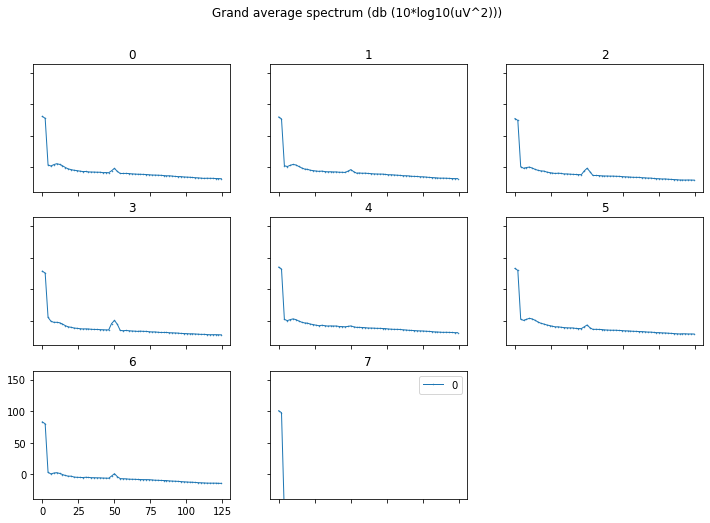

In [5]:
X, Y, coords = load_mindaffectBCI(savefile, stopband=None, fs_out=None)
# output is: X=eeg, Y=stimulus, coords=meta-info about dimensions of X and Y
print("EEG: X({}){} @{}Hz".format([c['name'] for c in coords],X.shape,coords[1]['fs']))                            
print("STIMULUS: Y({}){}".format([c['name'] for c in coords[:-1]]+['output'],Y.shape))
# Plot the grand average spectrum to get idea of the signal quality
from mindaffectBCI.decoder.preprocess import plot_grand_average_spectrum
plot_grand_average_spectrum(X, fs=coords[1]['fs'], ch_names=coords[-1]['coords'], log=True)

Text(0, 0.5, 'Trial#')

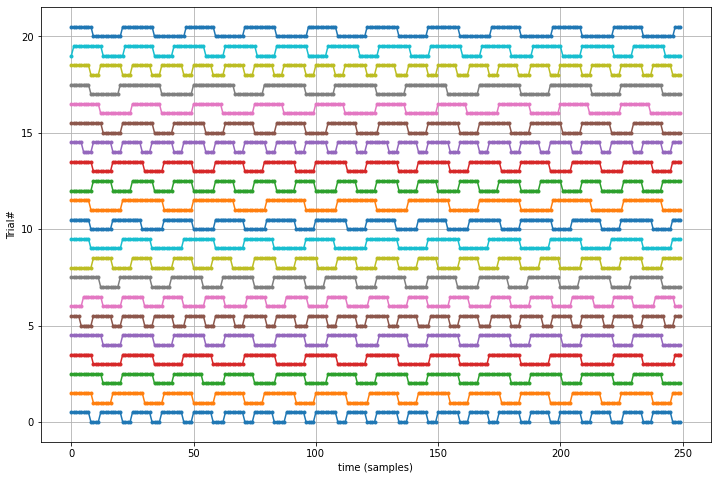

In [30]:
fs=coords[1]['fs']
Ytrue=Y[:21,:,0]
t=plt.plot(Ytrue[:,int(fs):int(2*fs)].T/2 + np.arange(Ytrue.shape[0])[np.newaxis,:],'.-')
plt.grid(True)
plt.xlabel('time (samples)')
plt.ylabel('Trial#')

## Reload the data, with standard preprocessing.

This time, we want to analysis the loaded data for the BCI signal.  Whilst we can do this after loading, to keep the analysis as similar as possible to the on-line system where the decoder only sees pre-processed data, we will reload wand apply the pre-processing directly.   This also has the benefit of making the datafile smaller. 

To reproduce the pre-processing done in the on-line BCI we will set the pre-processing to:
  * temporally filter the data to the BCI relevant range.  Temporal filtering is a standard technique to remove sigal frequencies which we know only contain noise.  For the noise-tag brain response we know it is mainly in the frequency range from 3 to about 25 Hz.  Thus, we specifcy a bandpass filter to only retain these frequencies with: 
  `stopband=(3,25,'bandpass')`
  * The orginal EEG is sampled 250 times per second.  However, the BCI relevant signal changes at most at 25 times per second, thus the EEG is sampled much more rapidly than needed -- so processing it takes undeeded computational resources.  Thus, we downsmaple the data to save some computation.  To avoid signal-artifacts, as a general 'rule of thumb' you should downsample to about 3 times your maximum signal frequency.  In this  case we use an output sample rate of 4 times, or 100 h with:
  `fs_out=100`

In [31]:
X, Y, coords = load_mindaffectBCI(savefile, stopband=(3,25,'bandpass'), fs_out=125)
# output is: X=eeg, Y=stimulus, coords=meta-info about dimensions of X and Y
print("EEG: X({}){} @{}Hz".format([c['name'] for c in coords],X.shape,coords[1]['fs']))                            
print("STIMULUS: Y({}){}".format([c['name'] for c in coords[:-1]]+['output'],Y.shape))

Loading C:\Users\Developer/Desktop/mark\mindaffectBCI_ssvep_bci_201117_1523.txt
X=(271831, 8) @250.4382669671926Hz
preFilter: 6th butter (3, 25, 'bandpass')Hz & downsample 250.4382669671926->125Hz
resample: 250.4382669671926->125.2191334835963hz rsrate=2.0
Got 90 trials, keeping 90
90 trl_dur (samp): [ 912  912  912  912  912  912  913  912  912  912  912  912  912  912
  912  912  912  912  911 7954  912  912  913  912  912  912  912  912
  912  912  912  912  912  912  912  913  912  912  912 7191 1514 1513
 1513 1513 1513 1512 1513 1514 1513 2800 1513 1514 1513 1513 1513 1513
 1513 1513 1513 4358 1513 1513 1513 1514 1513 1513 1513 1513 1513 5007
 1513 1513 1514 1513 1513 1513 1513 1513 1513 2319 1513 1513 1514 1513
 1513 1513 1513 1513 1514]
90 trl_dur (ms) : [ 7283.  7284.  7282.  7284.  7283.  7284.  7284.  7282.  7284.  7283.
  7283.  7283.  7284.  7283.  7284.  7283.  7284.  7283.  7282. 63518.
  7282.  7284.  7283.  7284.  7283.  7284.  7282.  7284.  7284.  7282.
  7284.  7284.

## Analyse the data

The following code runs the standard initial analysis and data-set visualization, in one go with some standard analysis parameters:

 * tau_ms : the length of the modelled stimulus response   (in milliseconds)
 
 * evtlabs : the type of brain feaatures to transform the stimulus information into prior to fitting the model in this case 
     * 're' -> rising edge    
     * 'fe' -> falling edge
   
   see `stim2event.py` for  more   information on possible transformations
 * rank  : the rank of  the CCA model to fit
 
 * model : the type of model to fit. 'cca' corrospends to the Cannonical Correlation Analysis model.

This generates many visualizations.  The most important are:

 1. **Summary Statistics**: Summary statistics for the data with, 
 This has vertically 3 sub-parts.
      row 1:   Cxx : this is the spatial cross-correlation of the EEG channels
      row 2:   Cxy : this is the cross-correlation of the stimulus with the EEG. Which for discrete stimuli as used in this BCI is essentially another view of the ERP.
      row 3:   Cyy : the auto-cross covariance of the stimulus features with the other (time-delayed) stimulus features

 <img src='images/SummaryStatistics.png' width=200>

 2. **Grand Average Spectrum** : This shows for each data channel the power over different signal frequencies.  This is useful to identify artifacts in the data,  which tend to show up as peaks in the spectrum at different frequencies, e.g. high power below 3Hz indicate movement artifacts, high power at 50/60hz indicates excessive line-noise interference. 

 <img src='images/GrandAverageSpectrum.png' width=200>


 3. **ERP** : This plot shows for each EEG channel the averaged measured response over time after the triggering stimulus. This is the conventional plot that you find in many neuroscientific publications.

 <img src='images/ERP.png' width=200>

 4. **Decoding Curve** + **Yerr** : The decoder accumulates information during a trial to make it's predictions better. These pair of plots show this information as a 'decoding curve'  which shows two important things:
   a) **Yerr** : which is the **true** error-rate of the systems predictions, with increasing trial time. 
   b) **Perr** : which is the systems own **estimation** of it's prediction error.  This estimation is used by the system to identify when it is confident enough to make a selection and stop a trial early.  Thus, this should ideally be as accurate as possible, so it's near 1 when Yerr is 1 and near 0 when Yerr is 0.  In the DecodingCurve plot Perr is shown by colored dots, with red being Yerr=1 and green being Yerr=0.  Thus, if the error estimates are good you should see red dots at the top left (wrong with short trials) and green dots at the bottom right (right with more data).

 <img src='images/DecodingCurve.png' width=200> <img src='images/Ycorrect.png' width=200>

 5. **Trial Summary** : This plot gives a direct trial-by-trial view of the input data and the BCI performance.  With each trial plotted individually running from left to right top to bottom.
  <img src='images/TrialSummary.png' width=400>
  
  Zooming in on a single trial, we see that vertically it has 5 sub-parts:
  
     a) **X** : this is the pre-processed input EEG data, with time horizontially, and channels with different colored lines vertically. 
     
     b) **Y** : this is the raw stimulus information, with time horizontially and outputs vertically.
     
     c) **Fe** : this is the systems predicted score for each type of stimulus-event, generated by applying the model to the raw EEG (e.g. 're','fe')
     
     d) **Fy** : this is the systems _accumulated_ predicted score for each output, generated by combining the predicted stimulus scores with the stimulus information.  Here the **true** output is in black with the other outputs in grey.  Thus, if the system is working correctly, the true output has the highest score and will be the highest line.
     
     e) **Py** : this is the systems **estimated** target probability for each output, generated by softmaxing the Fy scores.  Again, the true target is in black with the others in grey.  So if the system is working well the black line is near 0 when it's incorrect, and then jumps to 1 when it is correct.
     
  <img src='images/TrialSummary_single.png' width=200>

 6. *Model*: plot of the fitted model, in two sub-plots with: a) the fitted models spatial-filter -- which shows the importance of each EEG channel, b) the models impulse response -- which shows how the brain responds over time to the different types of stimulus event

 <img src='images/ForwardModel.png' width=200>

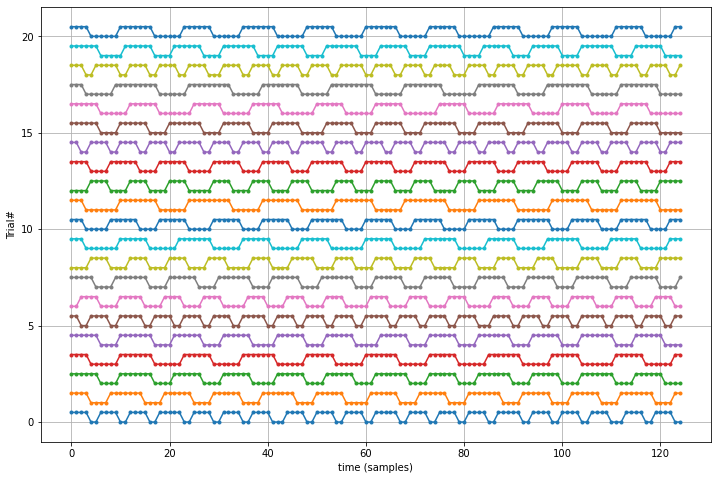

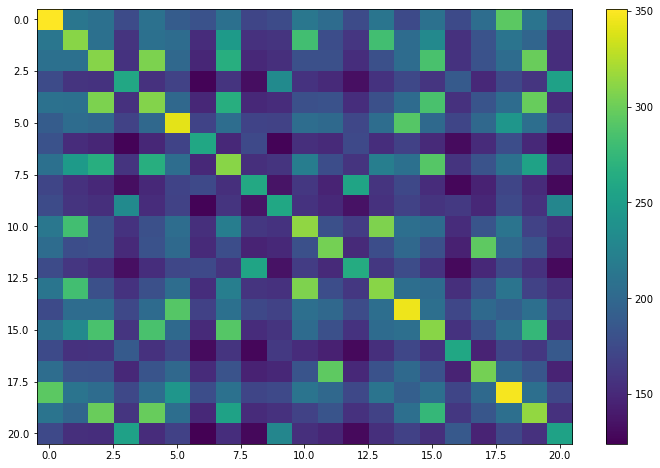

In [35]:
fs=coords[1]['fs']
Ytrue=Y[:21,:,0]
t=plt.plot(Ytrue[:,int(fs):int(2*fs)].T/2 + np.arange(Ytrue.shape[0])[np.newaxis,:],'.-')
plt.grid(True)
plt.xlabel('time (samples)')
plt.ylabel('Trial#')
plt.show()

plt.imshow(Ytrue@Ytrue.T,aspect='auto');plt.colorbar();plt.show()


X(['trial', 'time', 'channel'])(90, 1376, 8)
Y=(90, 1376, 10)
fs=125.2191334835963
Plot summary stats


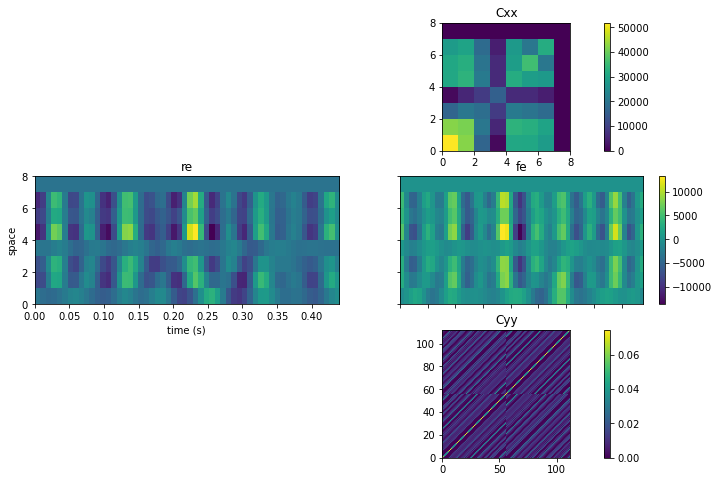

Plot global spectral properties
FX=(90, 32, 8)
erp=(1, 32, 8)


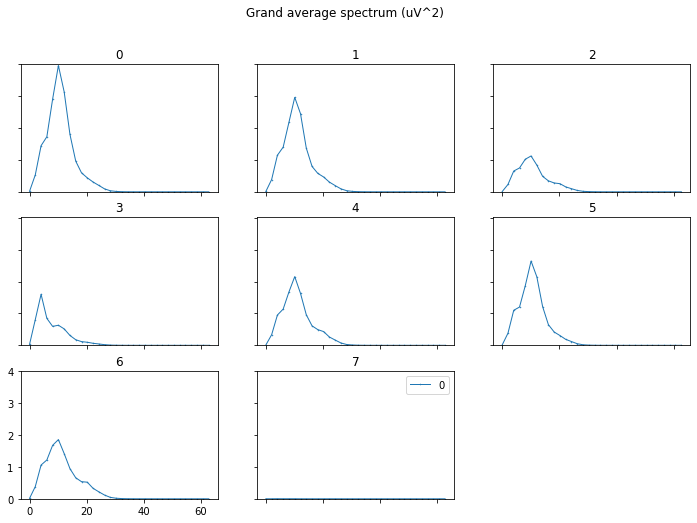

Plot ERP
erp=(2, 56, 8)


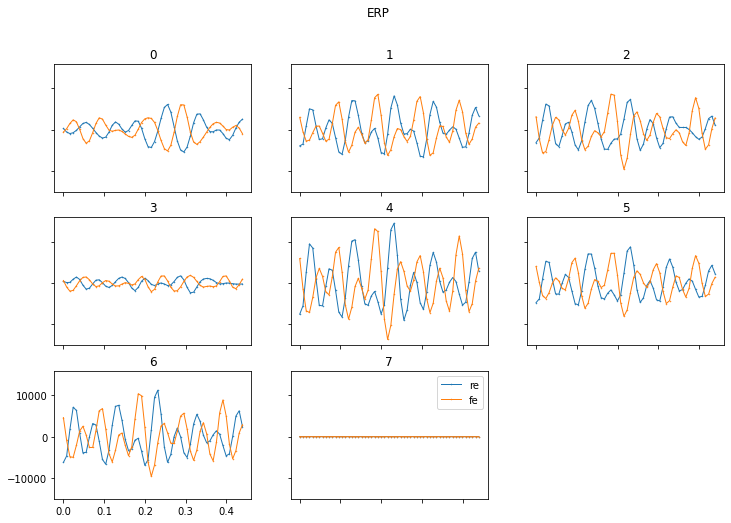

X(['trial', 'time', 'channel'])=(90, 1376, 8), Y=(90, 1376, 10) @125.2191334835963hz
Cscale=4.607522964477539
Sigma0 = 0.13366547226905823
softmaxscale=2.5
MultiCCA(CCA=True, badEpThresh=6, bwdAccumulate=False, center=True,
         evtlabs=('re', 'fe'), minDecisLen=100, offset=0,
         prediction_offsets=None, priorweight=200, rank=1,
         rcond=(0.0001, 1e-08), reg=(1e-08, None), startup_correction=100,
         symetric=False, tau=56)
score=0.6213582041343669
Int Lens:..............................

            IntLen   183   366   504   688   871  1009  1192  1376 
              Perr  0.48  0.44  0.43  0.38  0.39  0.39  0.38  0.37   AUDC 40.7
         Perr(est)  0.70  0.51  0.41  0.39  0.36  0.36  0.36  0.36   PSAE 40.5
           StopErr  0.50  0.41  0.40  0.38  0.37  0.37  0.37  0.37   AUSC 36.6
     StopThresh(P)  0.73  0.64  0.59  0.48  0.43  0.38  0.35  0.35   SSAE 82.0



<Figure size 864x576 with 0 Axes>

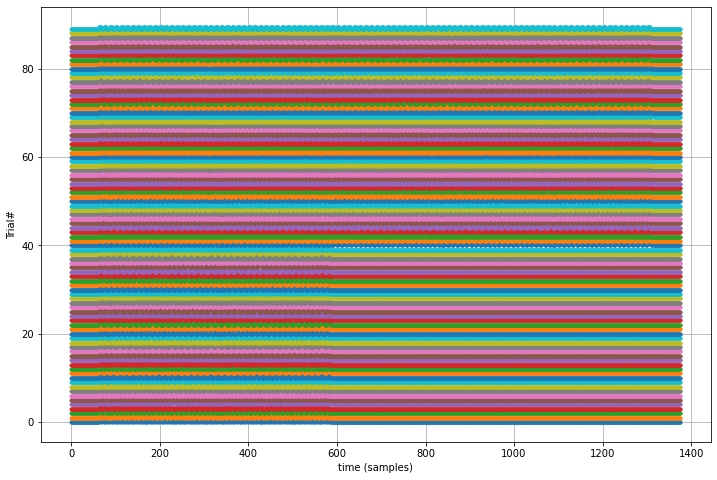

C:\Users\Developer\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


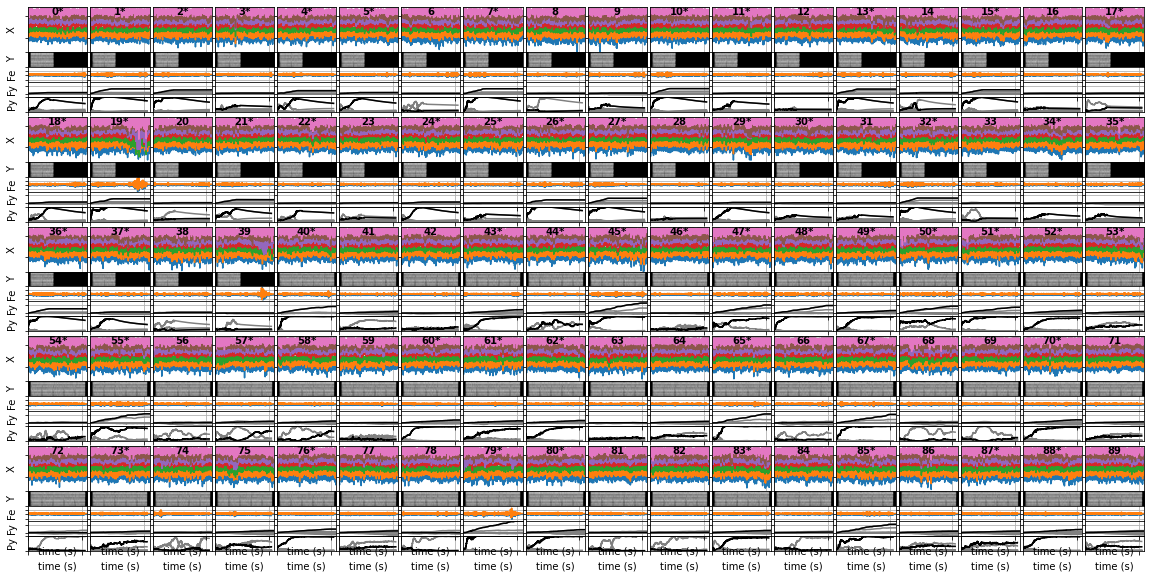

<Figure size 1080x648 with 0 Axes>

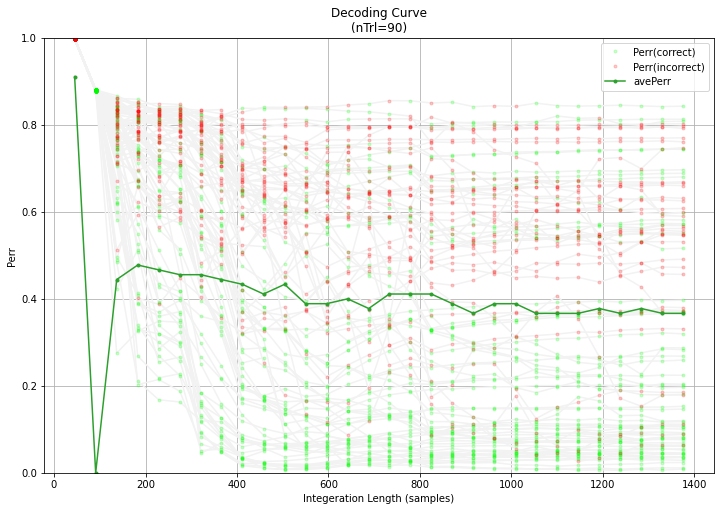

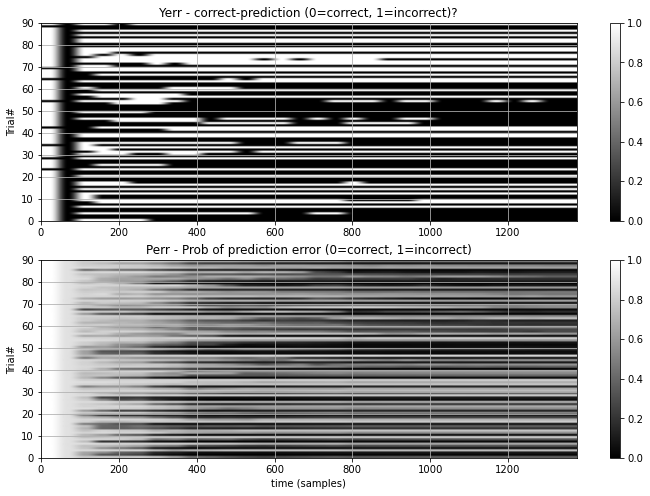

Plot Model
erp=(2, 56, 8)


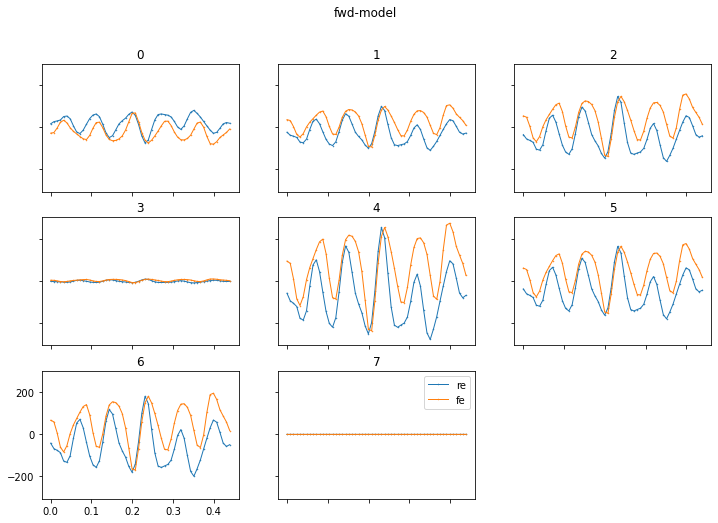

Plot Factored Model
Plot Factored Model
A=(1, 8) R=(1, 2, 56)


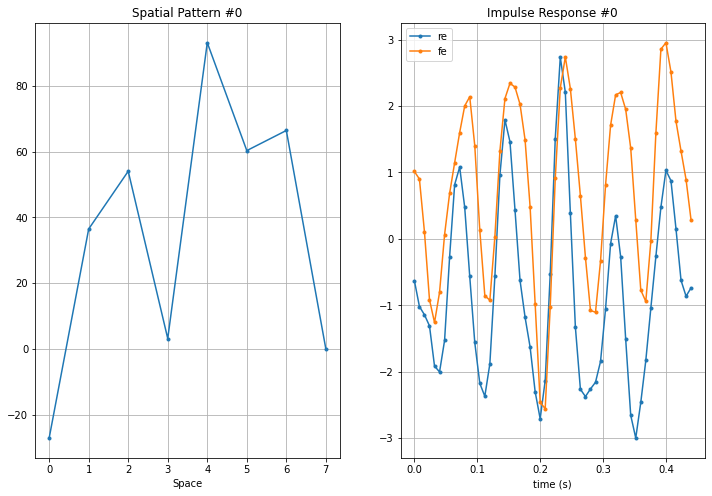

In [33]:
clsfr=debug_test_dataset(X, Y, coords,
                         model='cca', evtlabs=('re','fe'), rank=1, tau_ms=450)

## Alternative Analyse
The basic analysis system has many parameters you can tweak to test different analysis methods.   The following code runs the standard initial analysis and data-set visualization, in one go with some standard analysis parameters:

tau_ms : the length of the modelled stimulus response (in milliseconds)
evtlabs : the type of brain feaatures to transform the stimulus information into prior to fitting the model in this case
're' -> rising edge
'fe' -> falling edge see stim2event.py for more information on possible transformations
rank : the rank of the CCA model to fit
model : the type of model to fit. 'cca' corrospends to the Cannonical Correlation Analysis model.
    other options include: 
    * 'ridge' = ridge-regression, 
    * 'fwd' = Forward Modelling, 
    * 'bwd' = Backward Modelling, 
    * 'lr' = logistic-regression, 
    * 'svc' = support vector machine
    
See the help for `mindaffectBCI.decoder.model_fitting.BaseSequence2Sequence` or `mindaffectBCI.decoder.analyse_datasets.analyse_dataset` for more details on the other options.


Here we use a Logistic Regression classifier to classify single stimulus-responses into rising-edge (re) or falling-edge (fe) responses.

Note: we also include some additional pre-processing in this case, which consists of:
  * **whiten** : this will do a spatial whitening, so that the data input to the classifier is **spatially** decorrelated.   This happens automatically with the CCA classifier, and has been found useful to suppress artifacts in the data.
  * **whiten_spectrum** : this will approximately decorrelate different frequencies in the data.  In effect this flattens the peaks and troughs in the data frequency spectrum.  This pre-processing also been found useful to suppress artifacts in the data.

Further, as this is now a classification problem, we set `ignore_unlabelled=True`.  This means that samples which are not either rising edges or falling edges will not be given to the classifier -- so in the end we train a simple binary classifier.

In [ ]:
# test different inner classifier.  Here we use a Logistic Regression classifier to classify single stimulus-responses into rising-edge (re) or falling-edge (fe) responses. 
debug_test_dataset(X, Y, coords,
                   preprocess_args=dict(badChannelThresh=3, badTrialThresh=None, whiten=.01, whiten_spectrum=.1),
                   model='lr', evtlabs=('re', 'fe'), tau_ms=450, ignore_unlabelled=True)